# Landau damping of 2D Langmuir wave

In [1]:
import numpy as np
from prettytable import PrettyTable
import os
import matplotlib.pyplot as plt
import plasmapy
import scipy.signal
import scipy.optimize as op
%config InlineBackend.figure_format = 'svg'

# Function definition

In [2]:
def eq4PDRM(w,k):
    wr,wi=w
    wc=complex(wr,wi)
    zeta = wc / k /v_th
    r = 1 + 1 / k**2 / l_D**2 * ( 1 + zeta*plasmapy.dispersion.plasma_dispersion_func(zeta) )
    return [r.real,r.imag]
def line(p, x):
    k, b = p
    return k*x+b

def errorWithLine(p, x, y):
    r = line(p, x)-y
    return r

def period(x):
    return (x[1]-x[0])/1.

def errPercent(a, b):
    r = abs(a-b)/b
    return r

## Parameters settings

In [68]:
kx = 0.5
Lx = 2*np.pi/kx
ky = 0.5
Ly = 2*np.pi/ky

nx = 256
ny = 256
num_per_cell = 100
N = num_per_cell*(nx-1)*(ny-1)
Te = 1  # 温度
me = 1

vmax = 5. # 速度最大值
max_steps = 200  # 最大时间步数
data_num = 2
q = np.sqrt(Lx*Ly/N)
v_th = np.sqrt(2*T)
dt = 0.1
path = '../../data/'
d = 0.1
# 等离子体参量
dens = N /Lx/Ly
l_D = np.sqrt( T / dens / q**2 ) # $\lambda_D^2$
w_pe = np.sqrt( dens * q**2 )

## Dispersion
$$1 + \frac{1}{ k^2 \lambda_D^2 } [1+\zeta Z(\zeta)]=0$$
- 其中$\zeta=\frac{\omega}{kv_{th}}$，$v_{th}=\sqrt{\frac{2kT}{m_e}}$

In [39]:
print("kx = ",kx)
s=op.root(lambda w:eq4PDRM(w,kx),[1,0.1])
w_theo = s.x[0]
r_theo = s.x[1]
print("w_theo = ",w_theo)
print("r_theo = ",r_theo)
print("1/r_theo = ", abs(1.0/r_theo))
print("bouns time", 1.0/np.sqrt(q*d*kx))

kx =  0.5
w_theo =  1.4156618886035603
r_theo =  -0.1533594669236515
1/r_theo =  6.520627777728519
bouns time 63.705973415711426


In [40]:
kvec = np.arange(.1,1.2,0.1)
table = PrettyTable(['k','k*l_D','w_r','w_i','v_p/v_th'])
for ki in kvec:
    s=op.root(lambda w:eq4PDRM(w,ki),[1,0.1])
    vp2vth=s.x[0]/ki/v_th
    ki4p=round(ki,6)
    kl4p=round(ki*l_D,6)
    wr4p=round(s.x[0],6)
    wi4p=round(s.x[1],6)
    vp4p=round(vp2vth,6)
    table.add_row([ki4p,kl4p,wr4p,wi4p,vp4p])
print(table)

+-----+-------+----------+-----------+----------+
|  k  | k*l_D |   w_r    |    w_i    | v_p/v_th |
+-----+-------+----------+-----------+----------+
| 0.1 |  0.1  | 1.015198 |    -0.0   | 7.178531 |
| 0.2 |  0.2  | 1.063984 |  -5.5e-05 | 3.761753 |
| 0.3 |  0.3  | 1.159846 |  -0.01262 | 2.733784 |
| 0.4 |  0.4  | 1.285057 | -0.066128 | 2.271681 |
| 0.5 |  0.5  | 1.415662 | -0.153359 | 2.002048 |
| 0.6 |  0.6  | 1.545707 |  -0.26411 | 1.821633 |
| 0.7 |  0.7  | 1.673866 | -0.392401 | 1.69086  |
| 0.8 |  0.8  | 1.799899 | -0.534552 | 1.590901 |
| 0.9 |  0.9  | 1.923865 | -0.688109 | 1.511531 |
| 1.0 |  1.0  | 2.045905 |  -0.85133 | 1.446673 |
| 1.1 |  1.1  | 2.166175 | -1.022919 | 1.39247  |
+-----+-------+----------+-----------+----------+


In [55]:
dataet = np.loadtxt(os.path.join(path,"tot_energy"))
dataep = np.loadtxt(os.path.join(path,"pot_energy"))
dataek = np.loadtxt(os.path.join(path,"kin_energy"))

t = np.linspace(0, max_steps, max_steps+1)

In [58]:
indexes, _ = scipy.signal.find_peaks(dataep, distance=5)
xep = indexes[0:4:1]
yep = np.log(dataep[xep])
para, nouse = op.leastsq(errorWithLine, [-1, 1], args=(xep, yep))
per_sim = period(xep) * dt
# Ep ~ E^2 ~ Exp(i 2 w t + 2 r t)
w_sim = 2*np.pi/per_sim/2
r_sim = para[0]/dt/2
wc_table=PrettyTable(['w_theo','w_sim','err w(%)','r_theo','r_sim','err r(%)'])
wc_table.add_row([w_theo,w_sim,errPercent(w_sim,w_theo)*100,r_theo,r_sim,errPercent(r_sim,r_theo)*100])
print(wc_table)

+--------------------+-------------------+--------------------+---------------------+----------------------+--------------------+
|       w_theo       |       w_sim       |      err w(%)      |        r_theo       |        r_sim         |      err r(%)      |
+--------------------+-------------------+--------------------+---------------------+----------------------+--------------------+
| 1.4156618886035603 | 1.427996660722633 | 0.8713077761272525 | -0.1533594669236515 | -0.16280897022248866 | -6.161669369613496 |
+--------------------+-------------------+--------------------+---------------------+----------------------+--------------------+


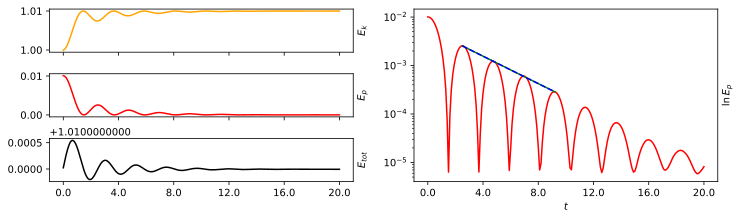

In [59]:
fig = plt.figure(figsize=(12, 3))
time_ticks = np.linspace(0,max_steps,num=6)

ax1 = plt.subplot2grid((3, 2), (0, 0))
ax1.plot(t, dataek, color='orange')
ax1.set_ylabel(r'$E_k$')
ax1.yaxis.set_label_position("right")
plt.xticks(time_ticks,[])

ax2 = plt.subplot2grid((3, 2), (1, 0))
ax2.plot(t, dataep, color='r')
ax2.set_ylabel(r'$E_p$')
ax2.yaxis.set_label_position("right")
plt.xticks(time_ticks,[])

ax3 = plt.subplot2grid((3, 2), (2, 0))
ax3.plot(t, dataet, color='black')
ax3.set_ylabel(r'$E_{tot}$')
ax3.yaxis.set_label_position("right")
plt.xticks(time_ticks,time_ticks*dt)

axl2 = plt.subplot2grid((3, 2), (0, 1), rowspan=3)
axl2.plot(t, dataep, color='r')
axl2.plot(xep,np.exp(line(para,xep)), '-',color='green')
axl2.plot(xep,np.exp(r_sim*xep*dt*2+para[1]), '--',color='blue')
axl2.set_ylabel(r'$\ln E_p$')
axl2.set_yscale('log')
axl2.yaxis.set_label_position("right")
plt.xticks(time_ticks,time_ticks*dt)

fig.subplots_adjust(bottom=0.1, top=0.9, hspace=.5, wspace=.2)
plt.xlabel(r'$t$')
plt.show()

In [60]:
progesses = np.arange(0,data_num,1)

e_xdata = []
e_ydata = []
e_vxdata = []
e_vydata = []

for progess in progesses:
    xdata_temp  = np.loadtxt(os.path.join(path,"electrons_x_data"+str(progess)))
    ydata_temp  = np.loadtxt(os.path.join(path,"electrons_y_data"+str(progess)))
    vxdata_temp = np.loadtxt(os.path.join(path,"electrons_vx_data"+str(progess)))
    vydata_temp = np.loadtxt(os.path.join(path,"electrons_vy_data"+str(progess)))
    e_xdata.append(xdata_temp)
    e_ydata.append(ydata_temp)
    e_vxdata.append(vxdata_temp)
    e_vydata.append(vydata_temp)

In [65]:
def pdf(data,data_bins):##统计分布函数
    f, edges = np.histogram(data, bins=data_bins, density=True)
    x = (edges[0:len(edges)-1]+edges[1:len(edges)])/2
    return f, x
def pdf2d(x,y,datax_bins,datay_bins):
    f,xedges,yedges = np.histogram2d(x,y,bins=[datax_bins,datay_bins],density=True)
    x = (xedges[0:len(xedges)-1]+xedges[1:len(xedges)])/2
    y = (yedges[0:len(yedges)-1]+yedges[1:len(yedges)])/2
    return f,x,y
def fm(v,m,T):
    r = np.sqrt(m/(2.*np.pi*T))*np.exp(-m*v**2/(2*T))
    return r

In [66]:
x_bins = 100
y_bins = 100
fev,vx_fev,vy_fev = pdf2d(e_vxdata[0],e_vydata[0],x_bins,y_bins)
fen,x_fen,y_fen = pdf2d(e_xdata[0],e_ydata[0],x_bins,y_bins)
fevx,vx_fevx = pdf(e_vxdata[1],x_bins)
fevy,vy_fevy = pdf(e_vydata[1],y_bins)
fex,x_fex = pdf(e_xdata[1],x_bins)
fey,y_fey = pdf(e_ydata[1],y_bins)
fevx0,vx_fevx0 = pdf(e_vxdata[0],x_bins)
fevy0,vy_fevy0 = pdf(e_vydata[0],y_bins)
fex0,x_fex0 = pdf(e_xdata[0],x_bins)
fey0,y_fey0 = pdf(e_ydata[0],y_bins)

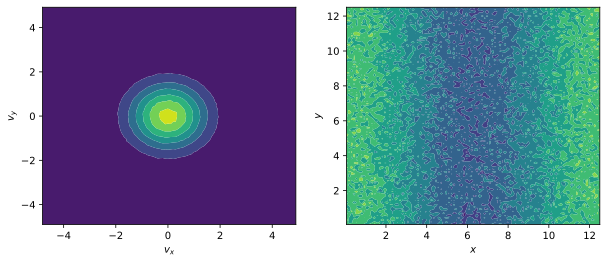

In [63]:
fig = plt.figure(figsize=(10,4))

ax1 = plt.subplot(121)
VY_fv,VX_fv = np.meshgrid(vy_fev,vx_fev)
ax1.contourf(VX_fv,VY_fv,fev)
ax1.set_xlabel(r'$v_x$')
ax1.set_ylabel(r'$v_y$')

ax2 = plt.subplot(122)
Y_fn,X_fn = np.meshgrid(y_fen,x_fen)
ax2.contourf(X_fn,Y_fn,fen)
ax2.set_xlabel(r'$x$')
ax2.set_ylabel(r'$y$')

plt.show()

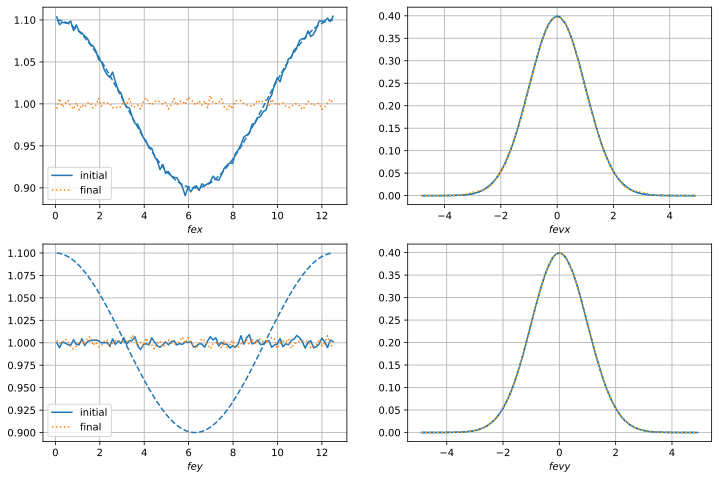

In [69]:
fig = plt.figure(figsize=(12,8))
ax1 = plt.subplot(221)
ax1.plot(x_fex0,fex0*Lx,color='tab:blue',label='initial')
ax1.plot(x_fex0,1+0.1*np.cos(kx*x_fex0),'--',color='tab:blue')
ax1.plot(x_fex,fex*Lx,':',color='tab:orange',label='final')
ax1.grid()
ax1.set_xlabel(r'$fex$')
ax1.legend()

ax2 = plt.subplot(222)
ax2.plot(vx_fevx0,fevx0,color='tab:blue')
ax2.plot(vx_fevx0,fm(vx_fevx0,me,Te),'--',color='tab:blue')
ax2.plot(vx_fevx,fevx,':',color='orange')
ax2.set_xlabel(r'$fevx$')
ax2.grid()

ax3 = plt.subplot(223)
ax3.plot(y_fey0,fey0*Ly,color='tab:blue',label='initial')
ax3.plot(y_fey0,1+0.1*np.cos(ky*y_fey0),'--',color='tab:blue')
ax3.plot(y_fey,fey*Ly,':',color='tab:orange',label='final')
ax3.grid()
ax3.set_xlabel(r'$fey$')
ax3.legend()

ax4 = plt.subplot(224)
ax4.plot(vy_fevy0,fevy0,color='tab:blue')
ax4.plot(vy_fevy0,fm(vy_fevy0,me,Te),'--',color='tab:blue')
ax4.plot(vy_fevy,fevy,':',color='orange')
ax4.set_xlabel(r'$fevy$')
ax4.grid()

plt.show()